<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Scikit-LLM/Flood_Prediction/Injuries_Direct/Flood_pred_inj_direct_work_single_step_v_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Injuries_Direct single step Flood Prediction  

### Prepare Workspace

In [ ]:
! pip install shap &> /dev/null

In [ ]:
! pip install optuna &> /dev/null

In [ ]:
! pip install catboost &> /dev/null

In [ ]:
! pip install dask[dataframe] &> /dev/null

In [ ]:
! pip install h2o &> /dev/null

In [ ]:
#setup deterministic results
import numpy as np
from numpy.random import seed
seed=0
np.random.seed(seed)


In [ ]:
# utils packages
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import datetime
import scipy
import scipy.stats as stats
import statsmodels
import sklearn
import lightgbm
import xgboost
import catboost
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import radians, sin, cos, sqrt, atan2
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import randint
import optuna


# packages for prediction and other utils functions
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import h2o
from h2o.estimators.gam import H2OGeneralizedAdditiveEstimator


# to evaluate models
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
import shap

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
np.__version__

'1.26.4'

In [ ]:
pd.__version__

'2.1.4'

In [ ]:
matplotlib.__version__

'3.7.1'

In [ ]:
sns.__version__

'0.13.1'

In [ ]:
scipy.__version__

'1.13.1'

In [ ]:
statsmodels.__version__

'0.14.2'

In [ ]:
sklearn.__version__

'1.3.2'

In [ ]:
optuna.__version__

'3.6.1'

In [ ]:
shap.__version__

'0.46.0'

In [ ]:
lightgbm.__version__

'4.4.0'

In [ ]:
xgboost.__version__

'2.1.1'

In [ ]:
catboost.__version__

'1.2.5'

In [ ]:
h2o.__version__

'3.46.0.4'

### Upload data set

In [ ]:
df=pd.read_csv('./flood_dataset.csv',index_col=0)

### Handling Date Time format

In [ ]:
# Trasform BEGIN_DATE_TIME and END_DATE_TIME in datetime format
df["BEGIN_DATE_TIME"] = pd.to_datetime(df["BEGIN_DATE_TIME"], format="%d-%b-%y %H:%M:%S")
df["END_DATE_TIME"] = pd.to_datetime(df["END_DATE_TIME"], format="%d-%b-%y %H:%M:%S")

In [ ]:
# Create index
df.index = pd.to_datetime(df.BEGIN_DATE_TIME)
df.index.names = ['Date']
# Sort DataFrame by date column in descending order
df.sort_values(by='Date', ascending = True, inplace = True)
# Sanity check: data span.
df.index.min(), df.index.max()

(Timestamp('2006-10-02 14:00:00'), Timestamp('2022-12-31 23:00:00'))

### Have a brief look of the data set

In [ ]:
df.shape

(38398, 31)

In [ ]:
df.columns

Index(['EVENT_ID', 'BEGIN_DATE_TIME', 'END_DATE_TIME', 'STATE', 'STATE_FIPS',
       'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'FLOOD_CAUSE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON',
       'END_LAT', 'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38398 entries, 2006-10-02 14:00:00 to 2022-12-31 23:00:00
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   EVENT_ID           38398 non-null  int64         
 1   BEGIN_DATE_TIME    38398 non-null  datetime64[ns]
 2   END_DATE_TIME      38398 non-null  datetime64[ns]
 3   STATE              38398 non-null  object        
 4   STATE_FIPS         38398 non-null  float64       
 5   EVENT_TYPE         38398 non-null  object        
 6   CZ_TYPE            38398 non-null  object        
 7   CZ_FIPS            38398 non-null  int64         
 8   CZ_NAME            38398 non-null  object        
 9   WFO                38398 non-null  object        
 10  CZ_TIMEZONE        38398 non-null  object        
 11  INJURIES_DIRECT    38398 non-null  int64         
 12  INJURIES_INDIRECT  38398 non-null  int64         
 13  DEATHS_DIRECT      38398 n

In [ ]:
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
num = df[num_cols]
num.columns

Index(['EVENT_ID', 'STATE_FIPS', 'CZ_FIPS', 'INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'BEGIN_RANGE', 'END_RANGE',
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON'],
      dtype='object')

In [ ]:
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
cat = df[obj_cols]
cat.columns

Index(['STATE', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'WFO', 'CZ_TIMEZONE',
       'SOURCE', 'FLOOD_CAUSE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_AZIMUTH', 'END_LOCATION', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE'],
      dtype='object')

### Build features

In [ ]:
# Created year, month, day, time begin/end feature
df_1 = df.copy()
df_1['YEAR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).year
df_1['MONTH_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).month
df_1['DAY_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).day
df_1['HOUR_BEGIN'] = pd.DatetimeIndex(df_1['BEGIN_DATE_TIME']).hour
df_1['YEAR_BEGIN']= df_1["YEAR_BEGIN"].astype("int64")
df_1['MONTH_BEGIN']= df_1["MONTH_BEGIN"].astype("int64")
df_1['DAY_BEGIN']= df_1["DAY_BEGIN"].astype("int64")
df_1['HOUR_BEGIN']= df_1["HOUR_BEGIN"].astype("int64")
df_1['YEAR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).year
df_1['MONTH_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).month
df_1['DAY_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).day
df_1['HOUR_END'] = pd.DatetimeIndex(df_1['END_DATE_TIME']).hour
df_1['YEAR_END']= df_1["YEAR_END"].astype("int64")
df_1['MONTH_END']= df_1["MONTH_END"].astype("int64")
df_1['DAY_END']= df_1["DAY_END"].astype("int64")
df_1['HOUR_END']= df_1["HOUR_END"].astype("int64")

In [ ]:
# Calculate the difference between dates and convert it to days and hours
df_1['DAY_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.days
df_1['HOUR_DURATION'] = (df_1['END_DATE_TIME'] - df_1['BEGIN_DATE_TIME']).dt.total_seconds() / 3600

In [ ]:
# Merge Origin and Destination to have a look at the round event
df_1['LOCATION_ORIGIN_DESTINATION'] = df_1['BEGIN_LOCATION']+'-'+df_1['END_LOCATION']
df_1['BEGIN_END_AZIMUTH'] = df_1['BEGIN_AZIMUTH']+'-'+df_1['END_AZIMUTH']

In [ ]:
# new target features
df_1['WHOLE_INJURIES'] = df_1['INJURIES_INDIRECT'] + df_1['INJURIES_DIRECT']
df_1['WHOLE_DEATHS'] = df_1['DEATHS_INDIRECT'] + df_1['DEATHS_DIRECT']
df_1['WHOLE_DAMAGE'] = df_1['DAMAGE_CROPS'] + df_1['DAMAGE_PROPERTY']

In [ ]:
# Distance of the event
def haversine_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = radians(row['BEGIN_LAT']), radians(row['BEGIN_LON'])
    lat2, lon2 = radians(row['END_LAT']), radians(row['END_LON'])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius_of_earth = 6371  # Earth's radius in kilometers
    distance = radius_of_earth * c

    return distance

In [ ]:
# Distance
df_1['DISTANCE'] = df_1.apply(haversine_distance, axis=1)
df_1['DISTANCE_RANGE']=df_1['END_RANGE']-df_1['BEGIN_RANGE']

In [ ]:
# Drop old variables replaced by new variables
df_2=df_1.copy()
df_2 = df_2.drop(['BEGIN_LOCATION','END_LOCATION','BEGIN_AZIMUTH','END_AZIMUTH',
                  'INJURIES_INDIRECT','DEATHS_INDIRECT','DAMAGE_CROPS',
                  'END_RANGE','BEGIN_RANGE','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON'], axis=1)

### Encoding

In [ ]:
df_encod=df_2.copy()

In [ ]:
# Define the function to encode top N and group others
def encode_top_n_and_group_others(df, column, n=10):
    # Calculate the top N classes
    top_n_classes = df[column].value_counts().index[:n]

    # Create a dictionary to map the top N classes to integers
    state_group = {state: i+1 for i, state in enumerate(top_n_classes)}

    # Map the states to their corresponding integer or '0' for others
    df[column] = df[column].map(state_group).fillna(0).astype(int)

    return df, state_group

def create_encoded_table(data, var_c, var_t):
    # Encode the categorical variable and group others
    encoded_data, state_group = encode_top_n_and_group_others(data, var_c)

    # Aggregate the data based on the encoded categories
    agg_data = encoded_data.groupby(var_c)[var_t].sum().reset_index()

    # Sort the aggregated data in decreasing order
    agg_data_sorted = agg_data.sort_values(by=var_t, ascending=False)

    # Create a lookup dictionary for original category labels
    reverse_state_group = {v: k for k, v in state_group.items()}
    reverse_state_group[0] = 'Others'

    # Add the original category labels to the table
    agg_data_sorted['Original Label'] = agg_data_sorted[var_c].map(reverse_state_group)

    return agg_data_sorted




In [ ]:
# grouping_STATE
result_table = create_encoded_table(df_encod, var_c='STATE', var_t='INJURIES_DIRECT')

# Display the table
result_table

,STATE,INJURIES_DIRECT,Original Label
0,0,35,Others
5,5,24,CALIFORNIA
8,8,11,ILLINOIS
7,7,10,INDIANA
3,3,8,KENTUCKY
10,10,8,ARKANSAS
2,2,5,MISSOURI
4,4,3,IOWA
6,6,2,OHIO
1,1,1,VIRGINIA


In [ ]:
# grouping_CZ_NAME
result_table = create_encoded_table(df_encod, var_c='CZ_NAME', var_t='INJURIES_DIRECT')

# Display the table
result_table

,CZ_NAME,INJURIES_DIRECT,Original Label
0,0,97,Others
3,3,7,JACKSON
8,8,3,FRANKLIN
2,2,0,MONTGOMERY
1,1,0,WASHINGTON
5,5,0,WOODRUFF
4,4,0,UNION
6,6,0,JEFFERSON
7,7,0,FREDERICK
9,9,0,GREENE


In [ ]:
# grouping_WFO
result_table = create_encoded_table(df_encod, var_c='WFO', var_t='INJURIES_DIRECT')

# Display the table
result_table

,WFO,INJURIES_DIRECT,Original Label
0,0,74,Others
2,2,12,PAH
6,6,8,LZK
9,9,8,BOX
8,8,2,ARX
5,5,2,ILN
7,7,1,PHI
1,1,0,LWX
4,4,0,SGF
3,3,0,FSD


In [ ]:
# grouping_CZ_TIMEZONE
result_table = create_encoded_table(df_encod, var_c='CZ_TIMEZONE', var_t='INJURIES_DIRECT')

# Display the table
result_table

,CZ_TIMEZONE,INJURIES_DIRECT,Original Label
1,2,48,CST-6
0,1,29,EST-5
2,3,25,PST-8
3,4,5,MST-7
4,5,0,AST-4
5,6,0,AKST-9
6,7,0,GST10
7,8,0,HST-10


In [ ]:
# grouping_SOURCE
result_table = create_encoded_table(df_encod, var_c='SOURCE', var_t='INJURIES_DIRECT')

# Display the table
result_table

,SOURCE,INJURIES_DIRECT,Original Label
0,0,36,Others
3,3,23,Law Enforcement
9,9,16,Broadcast Media
2,2,12,Emergency Manager
10,10,9,Other Federal Agency
1,1,5,River/Stream Gage
6,6,5,Trained Spotter
8,8,1,Public
4,4,0,Department of Highways
5,5,0,Official NWS Observations


In [ ]:
# grouping_FLOOD_CAUSE
result_table = create_encoded_table(df_encod, var_c='FLOOD_CAUSE', var_t='INJURIES_DIRECT')

# Display the table
result_table

,FLOOD_CAUSE,INJURIES_DIRECT,Original Label
0,1,90,Heavy Rain
1,2,16,Heavy Rain / Snow Melt
2,3,1,Heavy Rain / Tropical System
3,4,0,Ice Jam
4,5,0,Planned Dam Release
5,6,0,Dam / Levee Break
6,7,0,Heavy Rain / Burn Area


In [ ]:
# grouping_BEGIN_END_AZIMUTH
result_table = create_encoded_table(df_encod, var_c='BEGIN_END_AZIMUTH', var_t='INJURIES_DIRECT')

# Display the table
result_table

,BEGIN_END_AZIMUTH,INJURIES_DIRECT,Original Label
0,0,89,Others
1,1,8,N-N
2,2,2,W-W
3,3,2,E-E
4,4,2,S-S
5,5,2,NW-NW
10,10,1,SW-SW
9,9,1,ENE-ENE
6,6,0,NNW-NNW
8,8,0,WNW-WNW


In [ ]:
# grouping_LOCATION_ORIGIN_DESTINATION
result_table = create_encoded_table(df_encod, var_c='LOCATION_ORIGIN_DESTINATION', var_t='INJURIES_DIRECT')

# Display the table
result_table

,LOCATION_ORIGIN_DESTINATION,INJURIES_DIRECT,Original Label
0,0,107,Others
1,1,0,SAN JUAN-SAN JUAN
2,2,0,RIVERSIDE-CAVELL
3,3,0,AUGUSTA-RUFFWOOD
4,4,0,SHAWNEETOWN-SHAWNEETOWN
5,5,0,PETERSBURG-PETERSBURG
6,6,0,AUGUSTA-AUGUSTA
7,7,0,PARADISE-PARADISE
8,8,0,BOSTON-BOSTON
9,9,0,MT VERNON-MT VERNON


### Remove Outliers

In [ ]:
df_3=df_encod.copy()

#### Fine-Tuning Isolation Forest

In [ ]:
# Create a custom scorer object
#poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

#param_grid = {
#    "contamination": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
#}

#iso_forest = IsolationForest(random_state=0)
#iso_forest_model = GridSearchCV(iso_forest, param_grid, cv=5, scoring=poisson_scorer)
#iso_forest_model.fit(df_3[['INJURIES_DIRECT','DEATHS_DIRECT','DAMAGE_PROPERTY',
#                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE']])

#print("Best parameters:", iso_forest_model.best_params_)

#### Fit the model

In [ ]:
def is_outlier(x):
    return 'yes' if x == -1 else 'no'

model = IsolationForest(contamination=0.01, random_state=0)
predictions = model.fit_predict(df_3[['INJURIES_DIRECT','DEATHS_DIRECT','DAMAGE_PROPERTY',
                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE']])
outliers = np.vectorize(is_outlier)(predictions)
outliers_series = pd.DataFrame(outliers, columns=['outliers'], index=df_3.index)
df_3_ = pd.concat([df_3, outliers_series], axis=1)

In [ ]:
df_3_.query('outliers=="yes"').shape

(384, 36)

In [ ]:
df_4 = df_3_.query('outliers=="no"')
df_4.shape

(38014, 36)

In [ ]:
# drop not useful features and targets not used
df_5=df_4.drop(['EVENT_ID','BEGIN_DATE_TIME','END_DATE_TIME','EPISODE_NARRATIVE',
                     'EVENT_NARRATIVE','EVENT_TYPE','CZ_TYPE','outliers','DEATHS_DIRECT','DAMAGE_PROPERTY',
                     'WHOLE_INJURIES','WHOLE_DEATHS','WHOLE_DAMAGE'], axis=1)


In [ ]:
target = df_5[['INJURIES_DIRECT']]
X_all = df_5.drop(['INJURIES_DIRECT'], axis=1)
X_all.shape

(38014, 22)

### Zero Variance Predictors

In [ ]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) ==0]
to_drop

[]

In [ ]:
# Drop features
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Normality Test

In [ ]:
# normality test
stat, p = shapiro(X_all_v)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
  print('Sample looks Gaussian (fail to reject H0)')
else:
  print('Sample does not look Gaussian (reject H0)')

Statistics=0.351, p=0.000
Sample does not look Gaussian (reject H0)


### Correlated Predictors

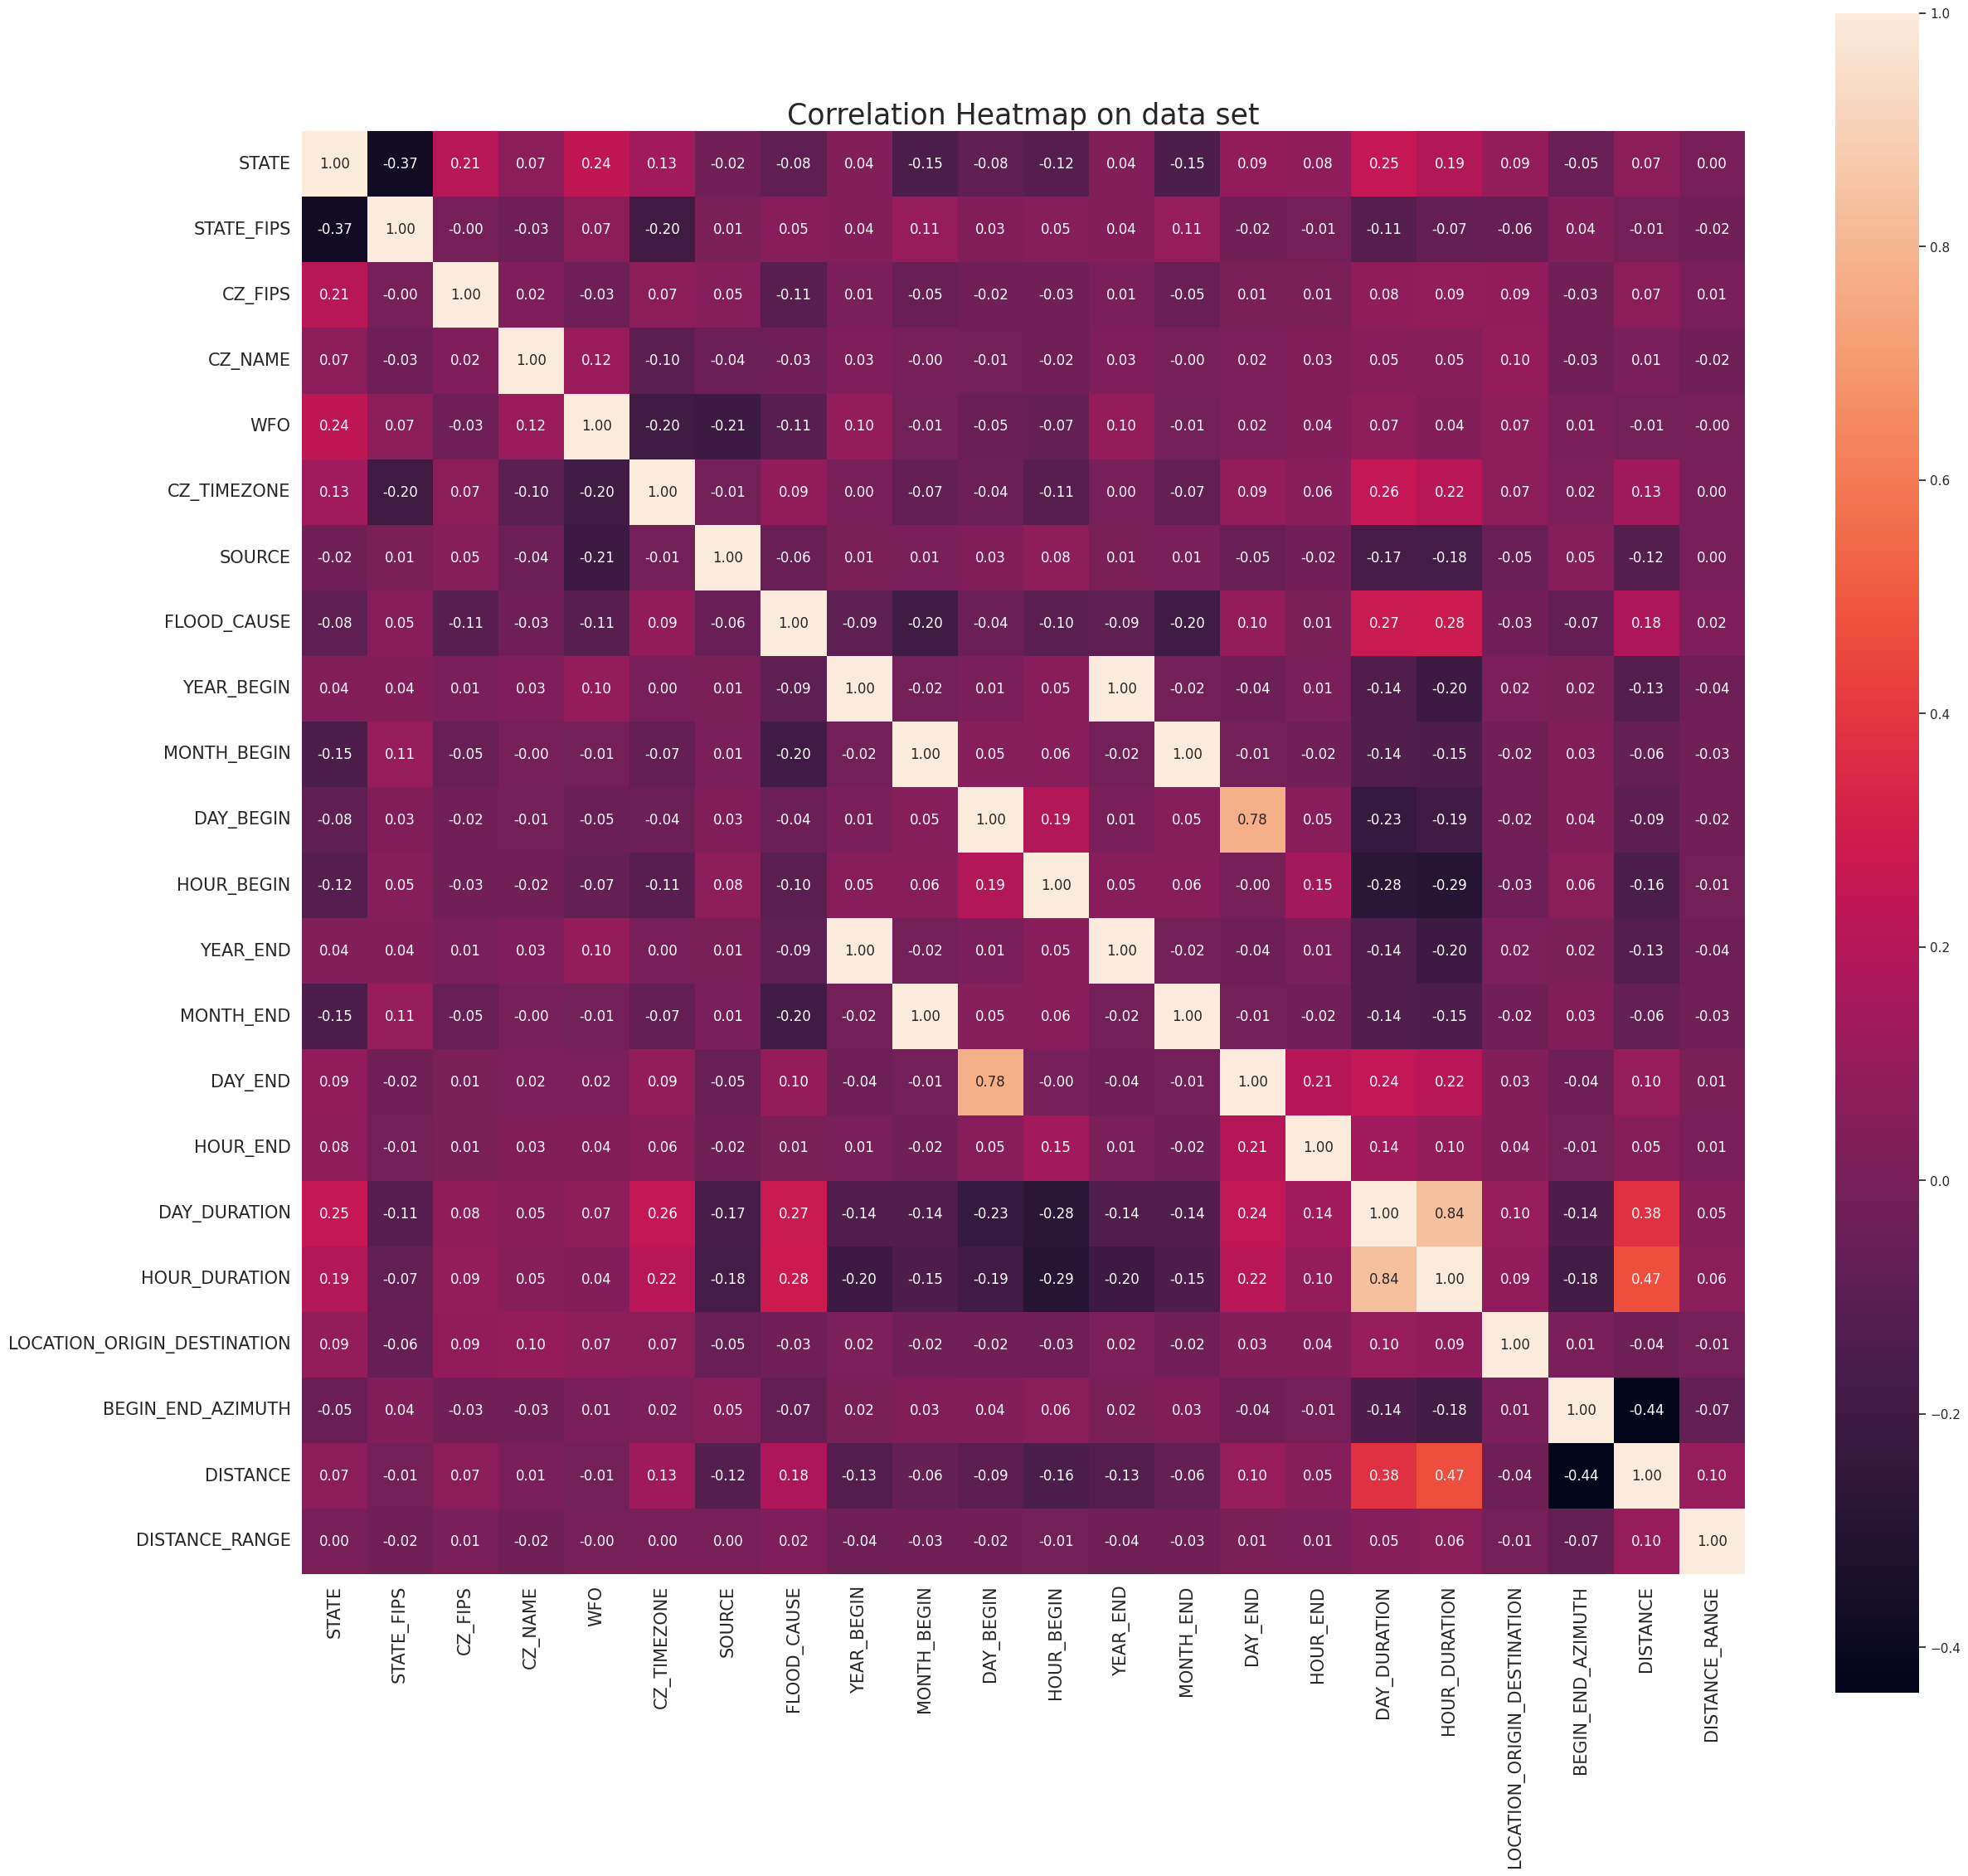

In [ ]:
# Correlation heatmap
corr_matrix = X_all.corr(method='spearman')
sns.set( rc = {'figure.figsize': (25, 25)})
sns.heatmap(corr_matrix, square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=25)
plt.yticks(fontsize="15")
plt.xticks(fontsize="15")
plt.show()

In [ ]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['YEAR_END', 'MONTH_END', 'DAY_END', 'HOUR_DURATION']

In [ ]:
# Drop features
X_all_f = X_all.drop(X_all[to_drop], axis=1)

In [ ]:
# Look at the new features data set
X_all_f.shape

(38014, 18)

### Feature Engineering with Lag and Rolling Window Features

In [ ]:
# Lag Features function
def lag_feat(df, var):
  df_lag = df.copy()
  lags = [1,7,30,90, 180, 270, 365]
  outcomes = [var]
  df_lag=df_lag.assign(**{
      f'{col} (t-{lag})': df_lag[col].shift(lag)
      for lag in lags
      for col in outcomes})
  # Remove nan values
  df_lag = df_lag.dropna()
  return df_lag

In [ ]:
# Rolling features function
def win_feat(df_lag, var):
  windows = [7, 30]
  outcomes = [var]
  df_lag_win = df_lag.copy()
  for window in windows:
    for col in outcomes:
        df_lag_win[f"{col} (r_w-{window}) mean"] = df_lag_win[col].rolling(window=window).mean()
  # Remove nan values
  df_lag_win = df_lag_win.dropna()
  return df_lag_win


In [ ]:
all = pd.concat([target, X_all_f], axis=1)


In [ ]:
all_lag=lag_feat(all, 'INJURIES_DIRECT')
all_lag_win=win_feat(all_lag, 'INJURIES_DIRECT')


### Split data set

In [ ]:
# Attach Target variable
# Split data set train/test set : test set is built on the last year
train = all_lag_win[all_lag_win.index < '2022-01-01']
test = all_lag_win[all_lag_win.index >= '2022-01-01']
len(train), len(test)

(35727, 1893)

In [ ]:
# split target and features
X_train = train.copy()
y_train = X_train.INJURIES_DIRECT
y_train = pd.DataFrame(y_train, columns=['INJURIES_DIRECT'])
X_train.drop(['INJURIES_DIRECT'], axis=1, inplace=True)
X_test = test.copy()
y_test = X_test.INJURIES_DIRECT
y_test = pd.DataFrame(y_test, columns=['INJURIES_DIRECT'])
X_test.drop(['INJURIES_DIRECT'], axis=1, inplace=True)
train_df = train.copy()
test_df = test.copy()




In [ ]:
# Apply the function to each row to create the exposure column
X_train['EXPOSURE'] = X_train.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
train_exposure=X_train.EXPOSURE
X_train.drop(['EXPOSURE'], axis=1, inplace=True)
X_test['EXPOSURE'] = X_test.groupby(['STATE','YEAR_BEGIN']).transform('count')['FLOOD_CAUSE']
test_exposure=X_test.EXPOSURE
X_test.drop(['EXPOSURE'], axis=1, inplace=True)

### Modelling & Evaluation

### GLM

#### Fine-Tuning

In [ ]:
# Fine tuning
#def objective(trial):
#    params = {
#        'power': trial.suggest_loguniform('power', 1, 1.5),
#         'alpha': trial.suggest_loguniform('alpha', 1e-4, 1.0),
#        'link':'log'
#    }
#    np.random.seed(0)
#    glm = TweedieRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)
#    mpd_scores = []

#    for train_index, val_index in tscv.split(X_train):
#        X_tr, X_val, tr_exposure, val_exposure = X_train.iloc[train_index], X_train.iloc[val_index], train_exposure[train_index], train_exposure[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        glm.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure)
#        pred_val = glm.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params


In [ ]:
#best_params

### Fit & Prediction

In [ ]:
np.random.seed(seed)
glm_tuned = TweedieRegressor(power=1.2475911541367166, alpha= 0.003321431099971064,link='log') # GLM with compound Poisson-Gamma distribution
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
glm_model = GridSearchCV(glm_tuned,param_grid,cv=tscv)
glm_model_fit=glm_model.fit(X_train, y_train.squeeze()/train_exposure.values,sample_weight=train_exposure.values)
score_glm = []
predictions_tr = glm_model_fit.predict(X_train)
predictions_te = glm_model_fit.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train.squeeze()/train_exposure.values, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze()/test_exposure.values, predictions_te))
mae_train = mean_absolute_error(y_train.squeeze()/train_exposure.values, predictions_tr)
mae_test = mean_absolute_error(y_test.squeeze()/test_exposure.values, predictions_te)
mpd_train = mean_poisson_deviance(y_train.squeeze()/train_exposure.values, predictions_tr)
mpd_test = mean_poisson_deviance(y_test.squeeze()/test_exposure.values, predictions_te)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_glm.append(score_dict)
score_glm = pd.DataFrame(score_glm, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_glm = pd.DataFrame(predictions_tr*train_exposure.values, columns = ['INJURIES_DIRECT_predict_glm'])
predictions_te_glm = pd.DataFrame(predictions_te*test_exposure.values, columns = ['INJURIES_DIRECT_predict_glm'])
train_df = pd.concat([train_df, predictions_tr_glm.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_glm.set_index(test_df.index)], axis=1)



### Evaluation

In [ ]:
glm_results = {'model':['glm'],
               'rmse_train':score_glm['rmse_train'],
               'rmse_test': score_glm['rmse_test'],
              'mae_train': score_glm['mae_train'],
              'mae_test': score_glm['mae_test'],
               'mpd_train': score_glm['mpd_train'],
               'mpd_test': score_glm['mpd_test']
               }
score_glm = pd.DataFrame(glm_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_glm

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,glm,0.000731,0.000251,0.000018,0.00001,0.000212,0.000092


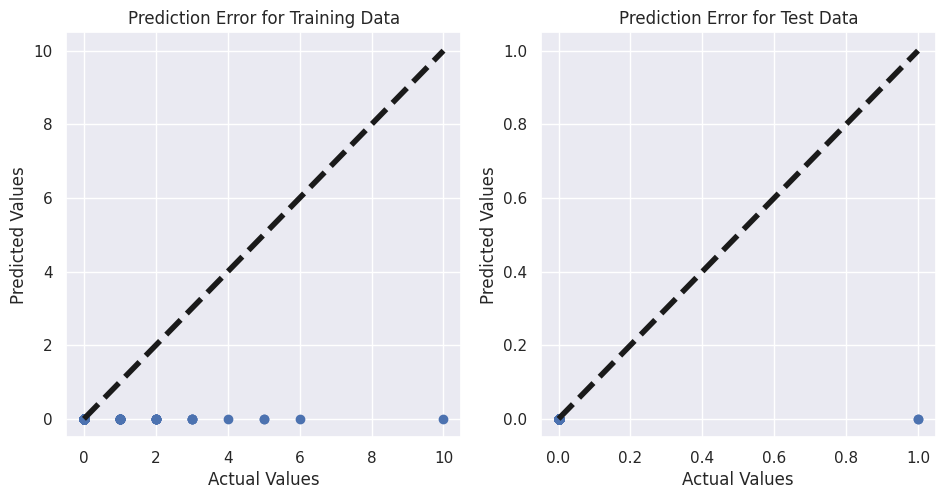

In [ ]:
# Plot prediction error
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_tr)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.title('Prediction Error for Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_te)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Prediction Error for Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


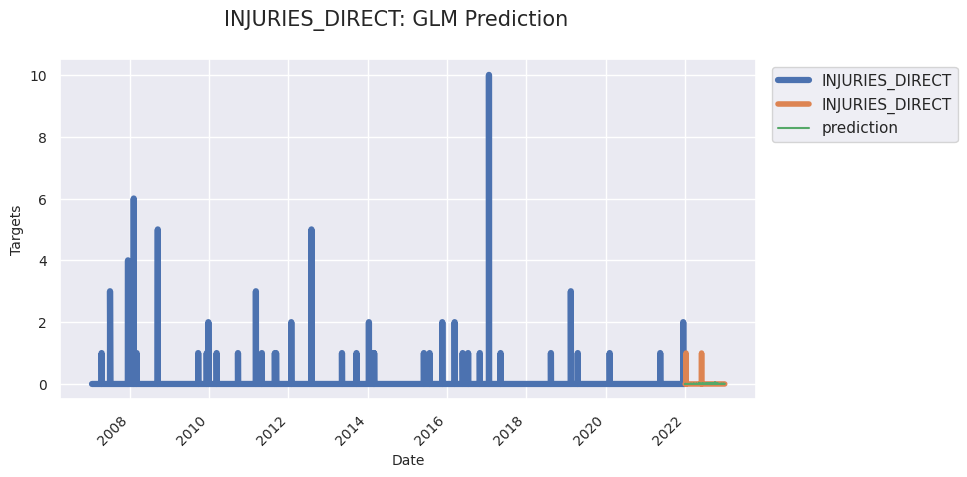

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(ax=ax, label='train',linewidth=4.5)
y_test.plot(ax=ax, label='test',linewidth=4)
test_df['INJURIES_DIRECT_predict_glm'].plot(ax=ax, label='prediction')
plt.suptitle('INJURIES_DIRECT: GLM Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

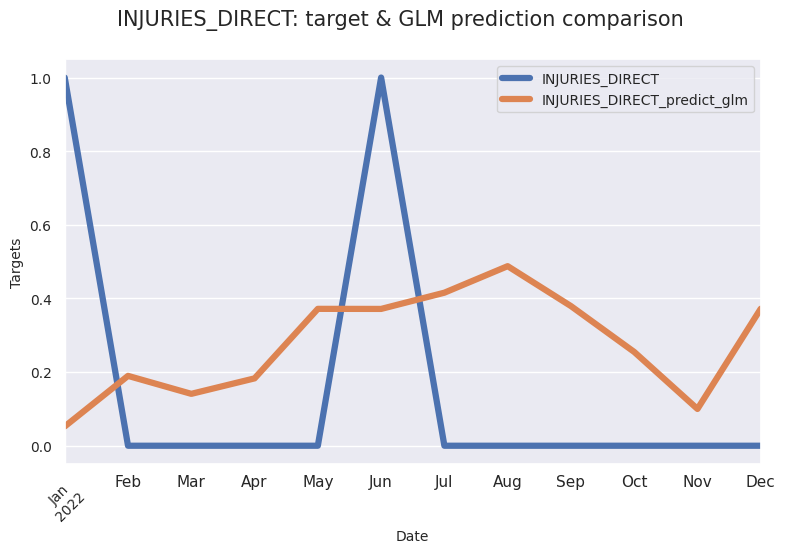

In [ ]:
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'INJURIES_DIRECT': 'sum',
    'INJURIES_DIRECT_predict_glm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('INJURIES_DIRECT: target & GLM prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

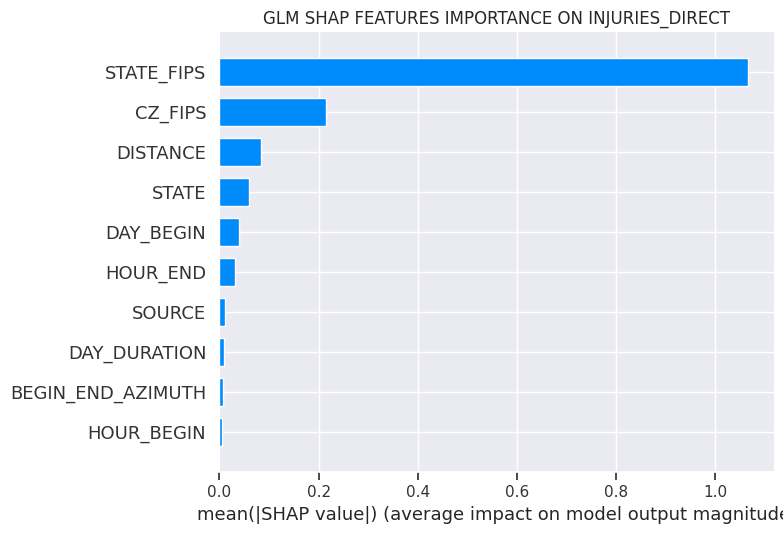

In [ ]:
# Global SHAP on GLM
GLM_ = TweedieRegressor(power=1.2475911541367166, alpha= 0.003321431099971064, link='log').fit(X_train, y_train.squeeze()/train_exposure.values,sample_weight=train_exposure.values)
masker = shap.maskers.Independent(X_train)
GLM_explainer = shap.LinearExplainer(GLM_, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON INJURIES_DIRECT")
shap.summary_plot(GLM_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar',max_display=10)

### GAM

In [ ]:
# Initialize H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpkkedbxyd
  JVM stdout: /tmp/tmpkkedbxyd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpkkedbxyd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,1 month and 4 days
H2O_cluster_name:,H2O_from_python_unknownUser_rmnpd6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Fine-tuning the model

In [ ]:
# Combine your training and test data
train_data = pd.concat([X_train, train_exposure, y_train], axis=1)
train_h2o = h2o.H2OFrame(train_data)

test_data = pd.concat([X_test, test_exposure, y_test], axis=1)
test_h2o = h2o.H2OFrame(test_data)

# Specify the columns for x and y
x = X_train.columns.tolist()
y = 'target'
weights_column = 'EXPOSURE'

# Add the 'target' column to the H2OFrame
train_h2o[y] = train_h2o['INJURIES_DIRECT'] / train_h2o[weights_column]

# Specify the gam_columns
gam_columns = ['STATE_FIPS', 'CZ_FIPS','YEAR_BEGIN', 'MONTH_BEGIN', 'DAY_BEGIN',
               'HOUR_BEGIN','HOUR_END', 'DISTANCE']


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Fit & Prediction

In [ ]:
# Combine your training and test data
train_data = pd.concat([X_train, train_exposure, y_train], axis=1)
train_h2o = h2o.H2OFrame(train_data)

test_data = pd.concat([X_test, y_test], axis=1)
test_h2o = h2o.H2OFrame(test_data)

# Specify the columns for x and y
x = X_train.columns.tolist()
y = 'target'
weights_column = 'EXPOSURE'

# Add the 'target' column to the H2OFrame
train_h2o[y] = train_h2o['INJURIES_DIRECT'] / train_h2o[weights_column]

# Specify the gam_columns
gam_columns = ['STATE_FIPS', 'YEAR_BEGIN', 'MONTH_BEGIN',
       'DAY_BEGIN', 'HOUR_BEGIN', 'HOUR_END','DISTANCE']


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Fine-tuning
#def objective(trial):
#    # Define the hyperparameter search space
#    #alpha = trial.suggest_float('alpha', 0.0, 0.4)
#    lambda_ = trial.suggest_loguniform('lambda', 1e-5, 0.5)


    # Define and train the model
#    gam_model = H2OGeneralizedAdditiveEstimator(
#        family='poisson',
#        seed=0,
#        nfolds=5,
#        weights_column=weights_column,
#        gam_columns=gam_columns,
#        alpha=alpha,
#        lambda_=lambda_,
#        max_iterations=1
#    )

    # Train the model
#    gam_model.train(x=x, y=y, training_frame=train_h2o)

    # Make predictions
#    predictions_test = gam_model.predict(test_h2o).as_data_frame().values.flatten()

    # Calculate evaluation metrics
#    rmse = np.sqrt(mean_squared_error(y_test.squeeze() / test_exposure.values, predictions_test))

#    return rmse




# Create optuna study and optimize
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)



In [ ]:
# Print best hyperparameters
#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))
#print("  Params: ")
#for key, value in trial.params.items():
#    print(f"    {key}: {value}")

In [ ]:
# Train the GAM model
gam_model = H2OGeneralizedAdditiveEstimator(family='poisson',
                                            seed=0,
                                            alpha=0.3276772379735403,
                                            lambda_=0.00000002781206848,
                                            nfolds=5,
                                            weights_column=weights_column,
                                            max_iterations=1,
                                            gam_columns=gam_columns)

gam_model.train(x=x, y=y, training_frame=train_h2o)

# Make predictions
score_gam = []
predictions_train = gam_model.predict(train_h2o).as_data_frame().values.flatten()
predictions_test = gam_model.predict(test_h2o).as_data_frame().values.flatten()

# Calculate evaluation metrics
rmse_train = np.sqrt(mean_squared_error(y_train.squeeze() / train_exposure.values, predictions_train))
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze() / test_exposure.values, predictions_test))
mae_train = mean_absolute_error(y_train.squeeze() / train_exposure.values, predictions_train)
mae_test = mean_absolute_error(y_test.squeeze() / test_exposure.values, predictions_test)
mpd_train = mean_poisson_deviance(y_train.squeeze() / train_exposure.values, predictions_train)
mpd_test = mean_poisson_deviance(y_test.squeeze() / test_exposure.values, predictions_test)

score_dict = {
    'rmse_train': rmse_train,
    'rmse_test': rmse_test,
    'mae_train': mae_train,
    'mae_test': mae_test,
    'mpd_train': mpd_train,
    'mpd_test': mpd_test
}


score_gam.append(score_dict)
score_gam = pd.DataFrame(score_gam, columns=['rmse_train', 'rmse_test', 'mae_train', 'mae_test', 'mpd_train', 'mpd_test'])

predictions_tr_gam = pd.DataFrame(predictions_train * train_exposure.values, columns=['INJURIES_DIRECT_predict_gam'])
predictions_te_gam = pd.DataFrame(predictions_test * test_exposure.values, columns=['INJURIES_DIRECT_predict_gam'])

train_df = pd.concat([train_df, predictions_tr_gam.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_gam.set_index(test_df.index)], axis=1)



gam Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gam prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gam prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Evaluation

In [ ]:
gam_results = {'model':['gam'],
               'rmse_train':score_gam['rmse_train'],
               'rmse_test': score_gam['rmse_test'],
               'mae_train': score_gam['mae_train'],
               'mae_test': score_gam['mae_test'],
               'mpd_train': score_gam['mpd_train'],
               'mpd_test': score_gam['mpd_test']
               }
score_gam = pd.DataFrame(gam_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_gam

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,gam,0.000727,0.000251,0.000019,0.000009,0.000137,0.000084


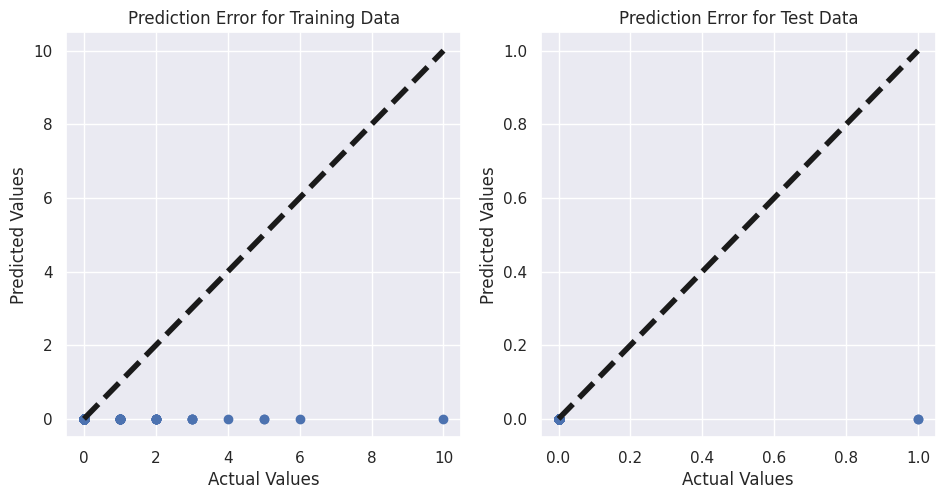

In [ ]:
# Plot prediction error
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_tr)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.title('Prediction Error for Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_te)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Prediction Error for Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


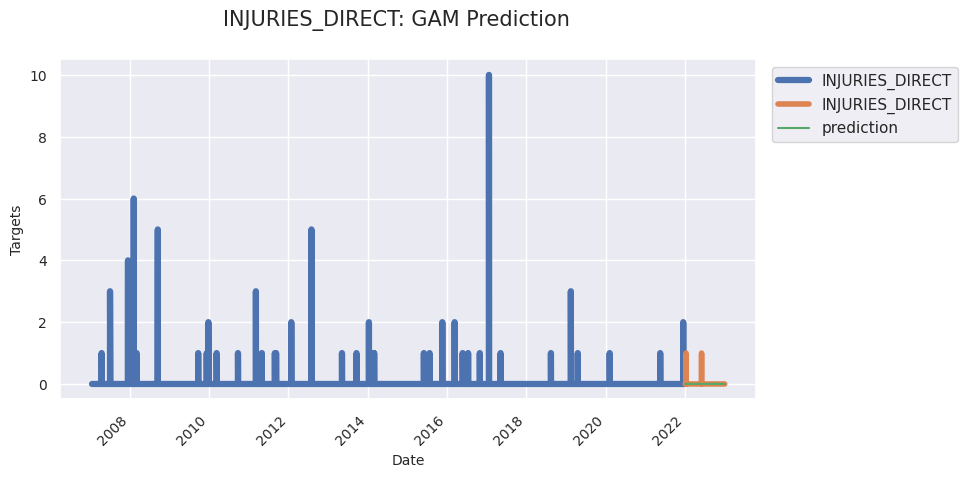

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(ax=ax, label='train',linewidth=4.5)
y_test.plot(ax=ax, label='test',linewidth=4)
test_df['INJURIES_DIRECT_predict_gam'].plot(ax=ax, label='prediction')
plt.suptitle('INJURIES_DIRECT: GAM Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

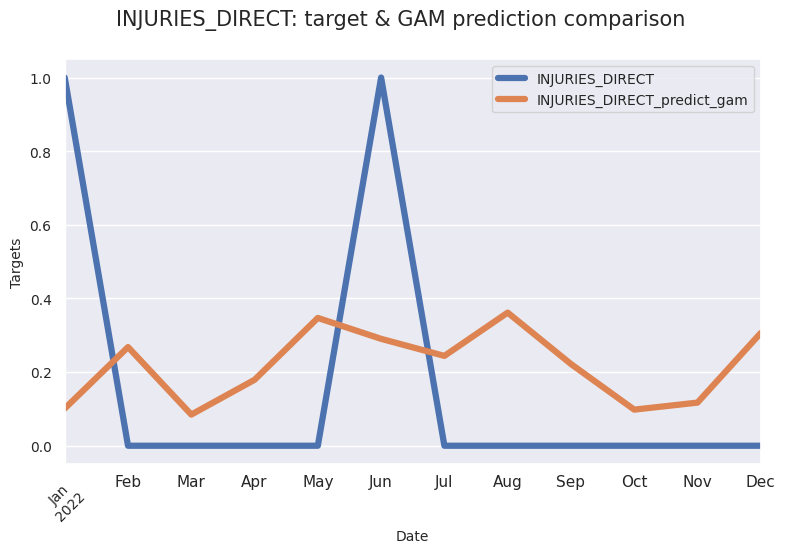

In [ ]:
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'INJURIES_DIRECT': 'sum',
    'INJURIES_DIRECT_predict_gam': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('INJURIES_DIRECT: target & GAM prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

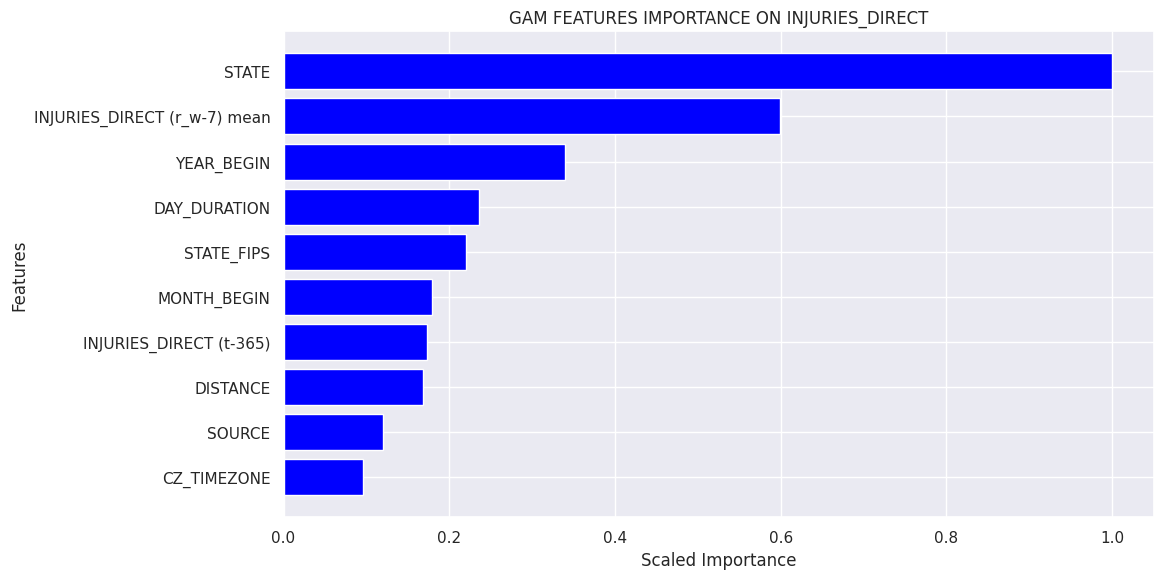

In [ ]:
varimp_db=pd.DataFrame(gam_model.varimp(use_pandas=True))

# Sort the DataFrame by 'scaled_importance' in descending order
top_features = varimp_db.nlargest(10, 'scaled_importance')

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['variable'], top_features['scaled_importance'], color='blue')
plt.xlabel('Scaled Importance')
plt.ylabel('Features')
plt.title('GAM FEATURES IMPORTANCE ON INJURIES_DIRECT')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [ ]:
# Clean up H2O cluster
h2o.shutdown(prompt=False)

H2O session _sid_b3d0 closed.


<ipython-input-86-73df0301fb97>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)





### LightGBM

#### Fine-tuning the model

In [ ]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'objective': 'poisson',
#        'random_state': 0,
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 8),
#        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
#        'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.1, 1.0)
#    }

#    lgbm = LGBMRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mpd_scores = []


#    for train_index, val_index in tscv.split(X_train):
#        X_tr, X_val, tr_exposure, val_exposure = X_train.iloc[train_index], X_train.iloc[val_index], train_exposure[train_index],train_exposure[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        lgbm.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure)
#        pred_val = lgbm.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params



In [ ]:
#best_params

#### Fit & Prediction

In [ ]:
lgbm_tuned =  LGBMRegressor(
    n_estimators= 313,
    learning_rate= 0.013787777316101502,
    max_depth= 6,
    num_leaves= 90,
    min_child_samples= 77,
    min_data_in_leaf= 60,
    bagging_fraction= 0.14445869142720172,
    objective='poisson',
    verbose= 0,
    random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}
lgbm_model = GridSearchCV(lgbm_tuned,param_grid,cv=tscv)
lgbm_model_fit=lgbm_model.fit(X_train, y_train.squeeze()/train_exposure.values,
               sample_weight=train_exposure.values)
score_lgbm=[]
predictions_tr = lgbm_model_fit.predict(X_train)
predictions_te = lgbm_model_fit.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train.squeeze()/train_exposure.values, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze()/test_exposure.values, predictions_te))
mae_train = mean_absolute_error(y_train.squeeze()/train_exposure.values, predictions_tr)
mae_test = mean_absolute_error(y_test.squeeze()/test_exposure.values, predictions_te)
mpd_train = mean_poisson_deviance(y_train.squeeze()/train_exposure.values, predictions_tr)
mpd_test = mean_poisson_deviance(y_test.squeeze()/test_exposure.values, predictions_te)

score_dict = {
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'mpd_train': mpd_train,
        'mpd_test': mpd_test
    }

score_lgbm.append(score_dict)
score_lgbm = pd.DataFrame(score_lgbm, columns = ['rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
predictions_tr_lgbm = pd.DataFrame(predictions_tr*train_exposure.values, columns = ['INJURIES_DIRECT_predict_lgbm'])
predictions_te_lgbm = pd.DataFrame(predictions_te*test_exposure.values, columns = ['INJURIES_DIRECT_predict_lgbm'])
train_df = pd.concat([train_df, predictions_tr_lgbm.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_lgbm.set_index(test_df.index)], axis=1)


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=0.14445869142720172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14445869142720172
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=0.14445869142720172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14445869142720172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

### Evaluation

In [ ]:
lgbm_results = {'model':['lgbm'],
               'rmse_train':score_lgbm['rmse_train'],
               'rmse_test': score_lgbm['rmse_test'],
               'mae_train': score_lgbm['mae_train'],
               'mae_test': score_lgbm['mae_test'],
               'mpd_train': score_lgbm['mpd_train'],
               'mpd_test': score_lgbm['mpd_test']
               }
score_lgbm = pd.DataFrame(lgbm_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_lgbm

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,lgbm,0.000605,0.000249,0.000016,0.000008,0.000037,0.000046


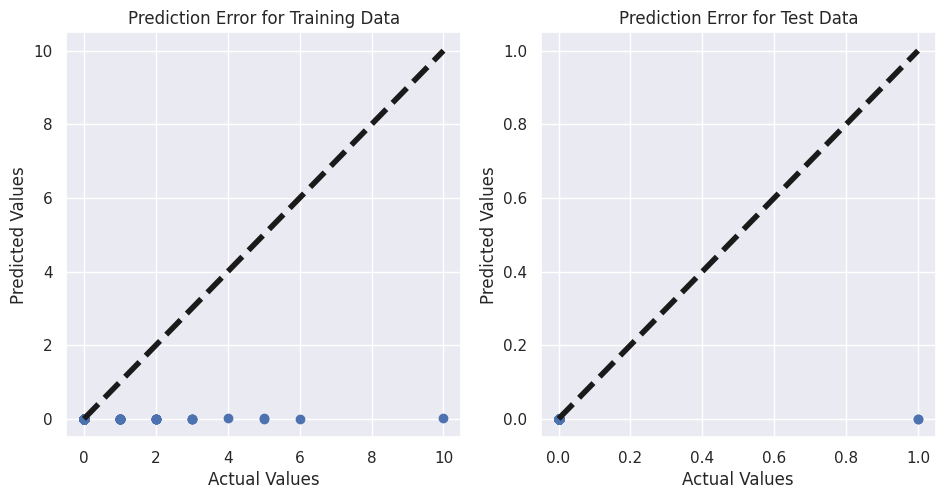

In [ ]:
# Plot prediction error
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_tr)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.title('Prediction Error for Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_te)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Prediction Error for Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


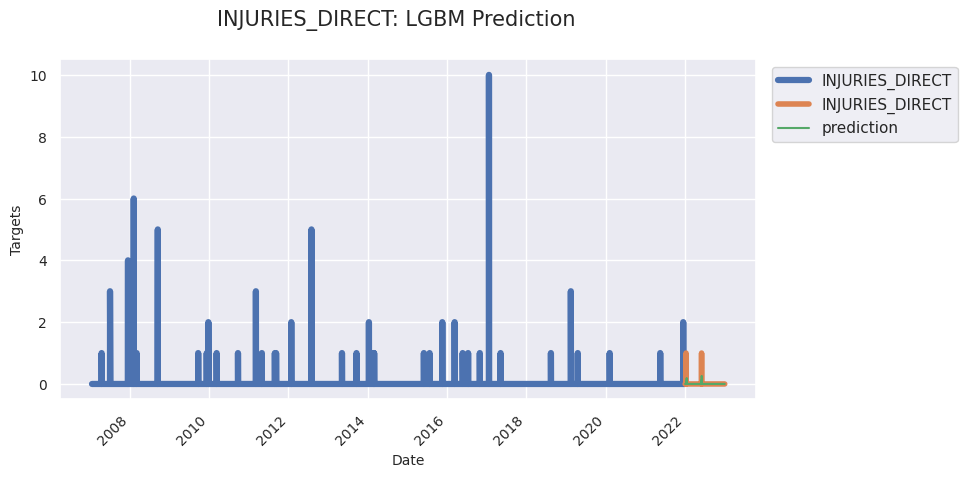

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(ax=ax, label='train',linewidth=4.5)
y_test.plot(ax=ax, label='test',linewidth=4)
test_df['INJURIES_DIRECT_predict_lgbm'].plot(ax=ax, label='prediction')
plt.suptitle('INJURIES_DIRECT: LGBM Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

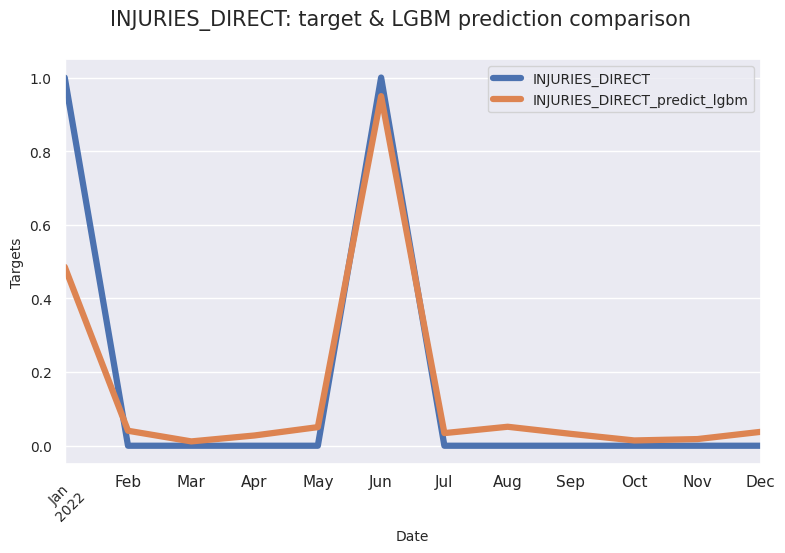

In [ ]:
# Plot results
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'INJURIES_DIRECT': 'sum',
    'INJURIES_DIRECT_predict_lgbm': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('INJURIES_DIRECT: target & LGBM prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=0.14445869142720172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14445869142720172
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_fraction is set=0.14445869142720172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14445869142720172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

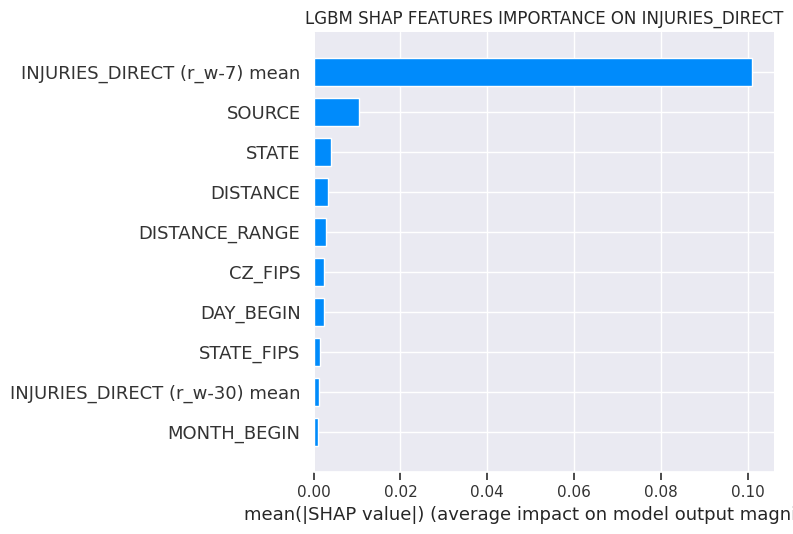

In [ ]:
# Global SHAP on LGBM
LGBM_ = LGBMRegressor(
    n_estimators= 313,
    learning_rate= 0.013787777316101502,
    max_depth= 6,
    num_leaves= 90,
    min_child_samples= 77,
    min_data_in_leaf= 60,
    bagging_fraction= 0.14445869142720172,
    objective='poisson',
    verbose=0,
    random_state=0).fit(X_train, y_train.squeeze()/train_exposure.values,
                        sample_weight=train_exposure.values)
LGBM_explainer = shap.TreeExplainer(LGBM_)
LGBM_shap_values = LGBM_explainer.shap_values(X_test)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("LGBM SHAP FEATURES IMPORTANCE ON INJURIES_DIRECT")
shap.summary_plot(LGBM_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar', max_display=10)

### XGBoost

#### Fine-tuning the model

In [ ]:
# fine-tuning
#def objective(trial):
#    params = {
#        'objective': 'reg:tweedie',
#        'tweedie_variance_power':1,
#        'random_state': 0,
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'max_depth': trial.suggest_int('max_depth', 3, 8),
#        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),  # For XGBoost equivalent to min_child_samples
#        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),  # For XGBoost equivalent to bagging_fraction
#        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1.0)  # Adding this as it can be important
#    }

#    xgb = XGBRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mpd_scores = []

#    for train_index, val_index in tscv.split(X_train):
#        X_tr, X_val, tr_exposure, val_exposure = X_train.iloc[train_index], X_train.iloc[val_index], train_exposure[train_index], train_exposure[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Adjusting the fit to account for sample_weights
#        xgb.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure)
#        pred_val = xgb.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params

In [ ]:
#best_params

#### Fit & Prediction

In [ ]:
# Define the model
xgb_tuned = XGBRegressor(
    n_estimators=612,
    learning_rate=0.03372974362415457,
    max_depth=7,
    min_child_weight=42,
    subsample=0.918252644171521,
    colsample_bytree=0.68137293881579,
    objective='reg:tweedie',
    tweedie_variance_power=1,
    verbose=0,
    random_state=0
)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}  # You can still add relevant XGBoost parameters here
xgb_model = GridSearchCV(xgb_tuned, param_grid, cv=tscv)

# Fit the model
xgb_model_fit=xgb_model.fit(X_train, y_train.squeeze() / train_exposure.values,
               sample_weight=train_exposure.values)

# Predictions
score_xgb = []
predictions_tr = xgb_model_fit.predict(X_train)
predictions_te = xgb_model_fit.predict(X_test)

# Calculate metrics
rmse_train = np.sqrt(mean_squared_error(y_train.squeeze() / train_exposure.values, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze() / test_exposure.values, predictions_te))
mae_train = mean_absolute_error(y_train.squeeze() / train_exposure.values, predictions_tr)
mae_test = mean_absolute_error(y_test.squeeze() / test_exposure.values, predictions_te)
mpd_train = mean_poisson_deviance(y_train.squeeze() / train_exposure.values, predictions_tr)
mpd_test = mean_poisson_deviance(y_test.squeeze() / test_exposure.values, predictions_te)

# Store the scores in a dictionary
score_dict = {
    'rmse_train': rmse_train,
    'rmse_test': rmse_test,
    'mae_train': mae_train,
    'mae_test': mae_test,
    'mpd_train': mpd_train,
    'mpd_test': mpd_test
}

score_xgb.append(score_dict)
score_xgb = pd.DataFrame(score_xgb, columns=['rmse_train', 'rmse_test', 'mae_train', 'mae_test', 'mpd_train', 'mpd_test'])

# Create DataFrames for predictions
predictions_tr_xgb = pd.DataFrame(predictions_tr * train_exposure.values, columns=['INJURIES_DIRECT_predict_xgb'])
predictions_te_xgb = pd.DataFrame(predictions_te * test_exposure.values, columns=['INJURIES_DIRECT_predict_xgb'])

# Concatenate predictions with training and test DataFrames
train_df = pd.concat([train_df, predictions_tr_xgb.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_xgb.set_index(test_df.index)], axis=1)

### Evaluation

In [ ]:
xgb_results = {'model':['xgb'],
               'rmse_train':score_xgb['rmse_train'],
               'rmse_test': score_xgb['rmse_test'],
              'mae_train': score_xgb['mae_train'],
              'mae_test': score_xgb['mae_test'],
              'mpd_train': score_xgb['mpd_train'],
              'mpd_test': score_xgb['mpd_test']
               }
score_xgb = pd.DataFrame(xgb_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_xgb

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,xgb,0.000679,0.000246,0.000018,0.000008,0.000058,0.000039


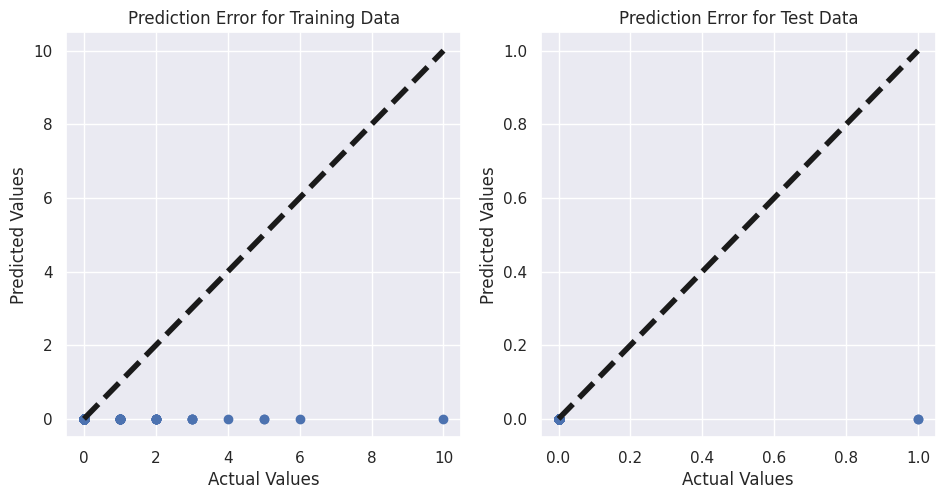

In [ ]:
# Plot prediction error
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_tr)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.title('Prediction Error for Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_te)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Prediction Error for Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


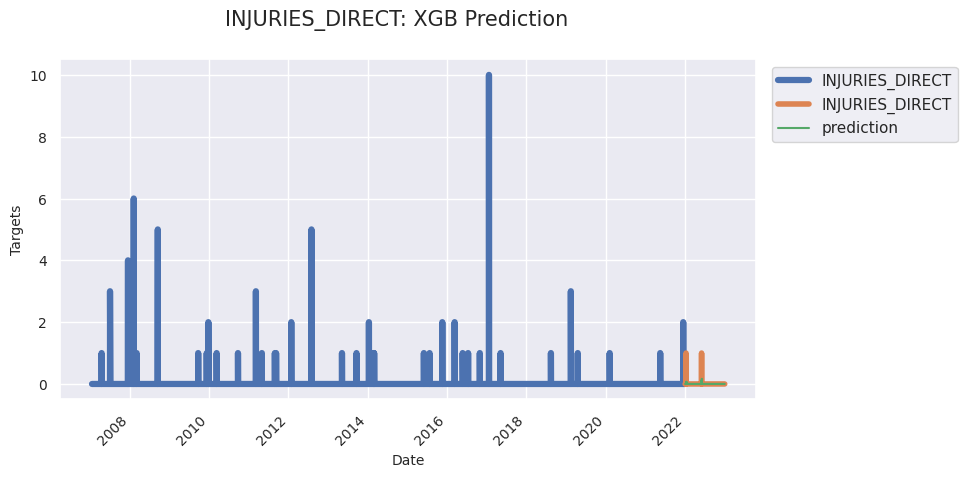

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(ax=ax, label='train',linewidth=4.5)
y_test.plot(ax=ax, label='test',linewidth=4)
test_df['INJURIES_DIRECT_predict_xgb'].plot(ax=ax, label='prediction')
plt.suptitle('INJURIES_DIRECT: XGB Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

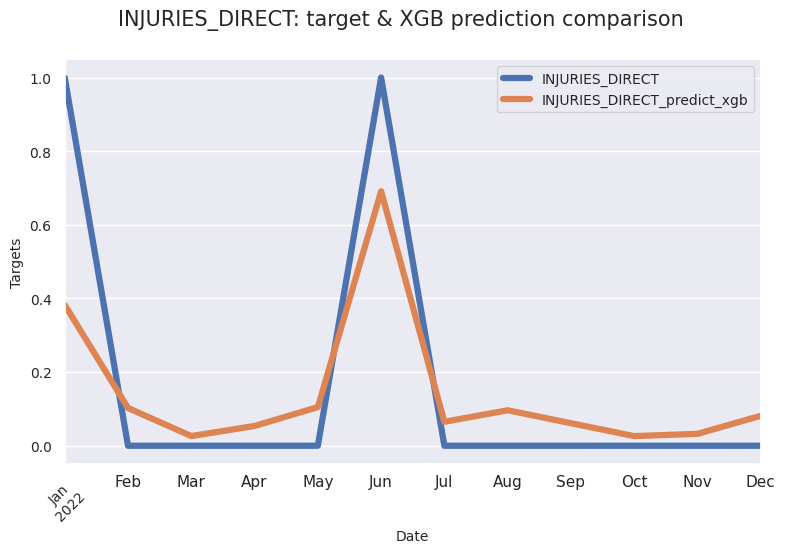

In [ ]:
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'INJURIES_DIRECT': 'sum',
    'INJURIES_DIRECT_predict_xgb': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('INJURIES_DIRECT: target & XGB prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

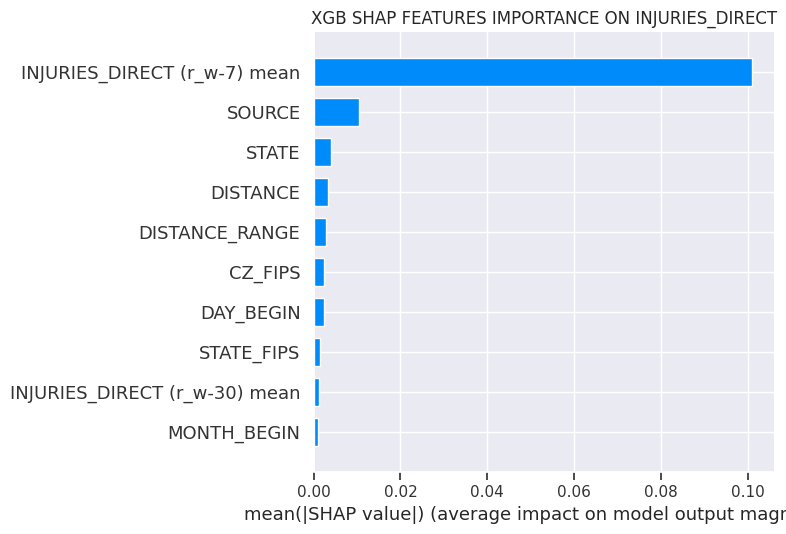

In [ ]:
# Global SHAP on XGB
xgb_ = XGBRegressor(
    n_estimators=612,
    learning_rate=0.03372974362415457,
    max_depth=7,
    min_child_weight=42,
    subsample=0.918252644171521,
    colsample_bytree=0.68137293881579,
    objective='reg:tweedie',
    tweedie_variance_power=1,
    verbose=0,
    random_state=0).fit(X_train, y_train.squeeze()/train_exposure.values,
                        sample_weight=train_exposure.values)
XGB_explainer = shap.TreeExplainer(xgb_)
XGB_shap_values = XGB_explainer.shap_values(X_test)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("XGB SHAP FEATURES IMPORTANCE ON INJURIES_DIRECT")
shap.summary_plot(LGBM_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar', max_display=10)

### CATBoost

#### Fine-tuning the model

In [ ]:
# Fine-tuning

#def objective(trial):
#    params = {
#        'loss_function': 'Poisson',
#        'random_seed': 0,
#        'iterations': trial.suggest_int('iterations', 50, 1000),
#        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#        'depth': trial.suggest_int('depth', 3, 8),
#        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
#        'rsm': trial.suggest_loguniform('rsm', 0.1, 1.0),
#        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
#        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
#    }

#    if params['bootstrap_type'] == 'Bayesian':
#        params['bagging_temperature'] = trial.suggest_loguniform('bagging_temperature', 0.01, 10.0)
#    elif params['bootstrap_type'] == 'Bernoulli':
#        params['subsample'] = trial.suggest_float('subsample', 0.1, 1.0)

#    catboost = CatBoostRegressor(**params)

#    tscv = TimeSeriesSplit(n_splits=5)

#    mpd_scores = []

#    for train_index, val_index in tscv.split(X_train):
#        X_tr, X_val, tr_exposure, val_exposure = X_train.iloc[train_index], X_train.iloc[val_index], train_exposure[train_index], train_exposure[val_index]
#        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

#        catboost.fit(X_tr, y_tr.squeeze()/tr_exposure, sample_weight=tr_exposure, verbose=0)
#        pred_val = catboost.predict(X_val)

#        mpd_score = mean_poisson_deviance(y_val.squeeze()/val_exposure, pred_val)
#        mpd_scores.append(mpd_score)

#    return np.mean(mpd_scores)

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=10)

#best_params = study.best_params

In [ ]:
#best_params

#### Fit & Prediction

In [ ]:
# Define the model
catboost_tuned = CatBoostRegressor(
    iterations=563,
    learning_rate=0.05952941019537914,
    depth=8,
    l2_leaf_reg=1.013175975630971,
    rsm=0.701318269813931,
    loss_function='Poisson',
    bootstrap_type= 'Bernoulli',
    grow_policy= 'Depthwise',
    subsample= 0.1857507239415918,
    random_state=0,
    verbose=0
)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {}  # Add relevant CatBoost parameters if needed
catboost_model = GridSearchCV(catboost_tuned, param_grid, cv=tscv)

# Fit the model
catboost_model_fit=catboost_model.fit(X_train, y_train.squeeze() / train_exposure.values,
                   sample_weight=train_exposure.values)

# Predictions
predictions_tr = catboost_model_fit.predict(X_train)
predictions_te = catboost_model_fit.predict(X_test)

# Calculate metrics
rmse_train = np.sqrt(mean_squared_error(y_train.squeeze() / train_exposure.values, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze() / test_exposure.values, predictions_te))
mae_train = mean_absolute_error(y_train.squeeze() / train_exposure.values, predictions_tr)
mae_test = mean_absolute_error(y_test.squeeze() / test_exposure.values, predictions_te)
mpd_train = mean_poisson_deviance(y_train.squeeze() / train_exposure.values, predictions_tr)
mpd_test = mean_poisson_deviance(y_test.squeeze() / test_exposure.values, predictions_te)

# Store the scores in a dictionary
score_dict = {
    'rmse_train': rmse_train,
    'rmse_test': rmse_test,
    'mae_train': mae_train,
    'mae_test': mae_test,
    'mpd_train': mpd_train,
    'mpd_test': mpd_test
}

score_cat = []
score_cat.append(score_dict)
score_cat = pd.DataFrame(score_cat, columns=['rmse_train', 'rmse_test', 'mae_train', 'mae_test', 'mpd_train', 'mpd_test'])

# Create DataFrames for predictions
predictions_tr_cat = pd.DataFrame(predictions_tr * train_exposure.values, columns=['INJURIES_DIRECT_predict_catboost'])
predictions_te_cat = pd.DataFrame(predictions_te * test_exposure.values, columns=['INJURIES_DIRECT_predict_catboost'])

# Concatenate predictions with training and test DataFrames
train_df = pd.concat([train_df, predictions_tr_cat.set_index(train_df.index)], axis=1)
test_df = pd.concat([test_df, predictions_te_cat.set_index(test_df.index)], axis=1)

#### Evaluation

In [ ]:
cat_results = {'model':['cat'],
               'rmse_train':score_cat['rmse_train'],
               'rmse_test': score_cat['rmse_test'],
              'mae_train': score_cat['mae_train'],
              'mae_test': score_cat['mae_test'],
              'mpd_train': score_cat['mpd_train'],
              'mpd_test': score_cat['mpd_test']
               }
score_cat = pd.DataFrame(cat_results,
                         columns=['model', 'rmse_train', 'rmse_test','mae_train','mae_test','mpd_train','mpd_test'])
score_cat

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,cat,0.000675,0.00025,0.000017,0.000009,0.000059,0.000053


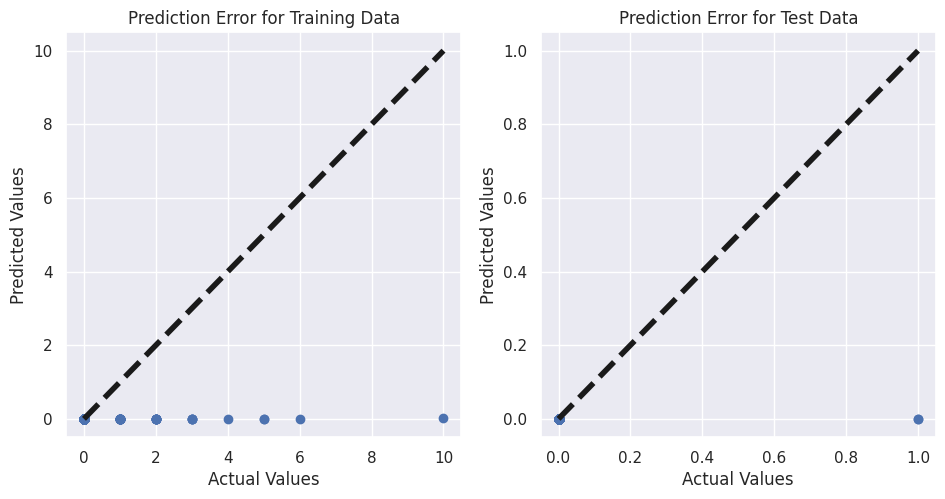

In [ ]:
# Plot prediction error
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, predictions_tr)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
plt.title('Prediction Error for Training Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions_te)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Prediction Error for Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


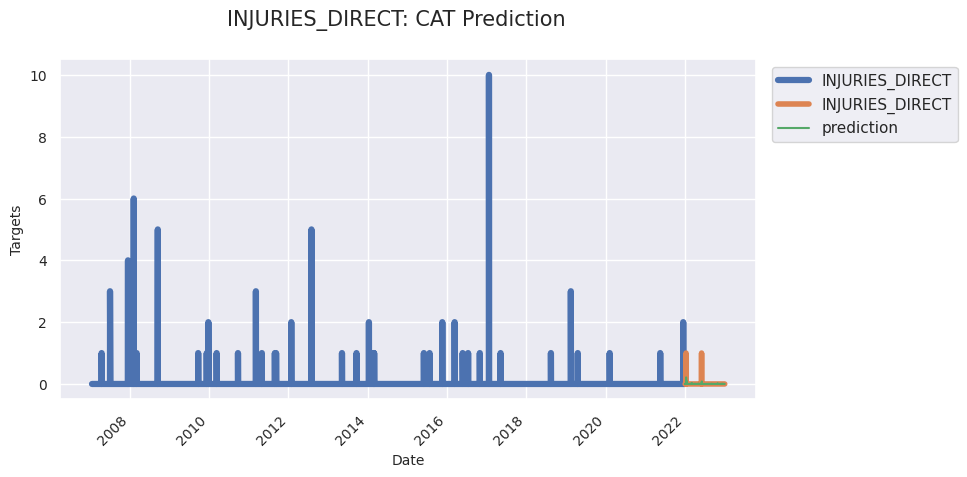

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(ax=ax, label='train',linewidth=4.5)
y_test.plot(ax=ax, label='test',linewidth=4)
test_df['INJURIES_DIRECT_predict_catboost'].plot(ax=ax, label='prediction')
plt.suptitle('INJURIES_DIRECT: CAT Prediction', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

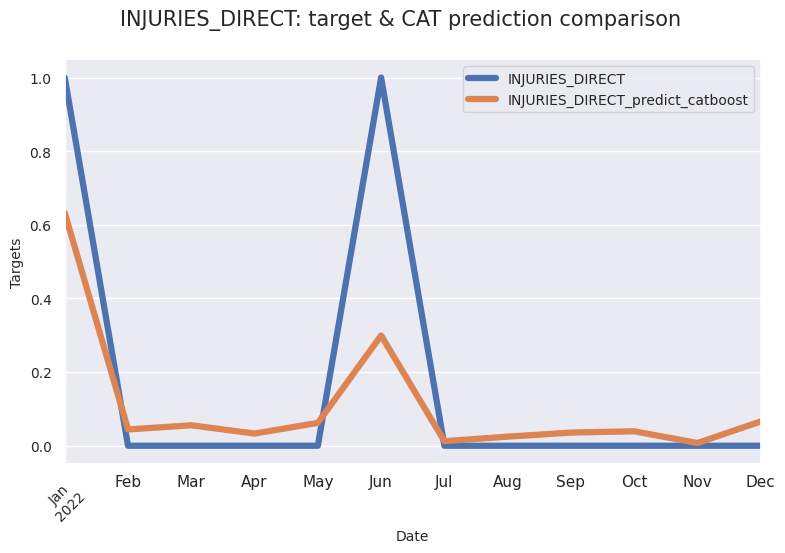

In [ ]:
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'INJURIES_DIRECT': 'sum',
    'INJURIES_DIRECT_predict_catboost': 'sum'})
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('INJURIES_DIRECT: target & CAT prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

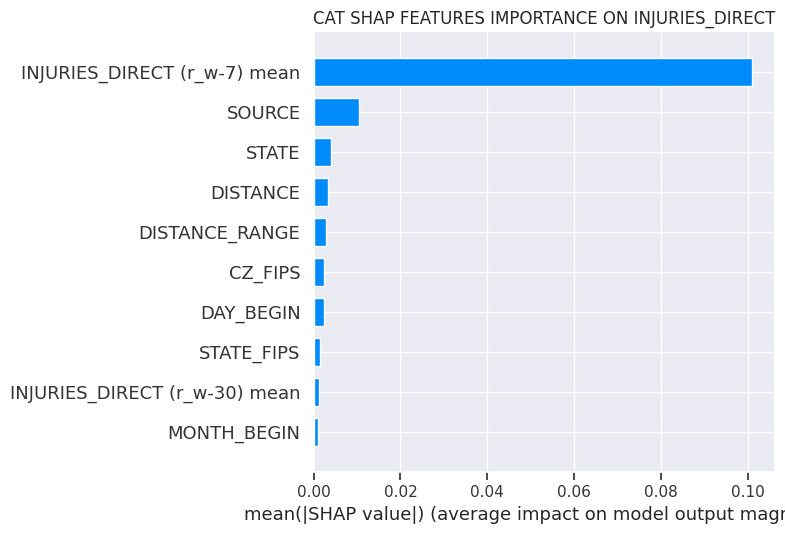

In [ ]:
# Global SHAP on CAT
catboost_ = CatBoostRegressor(
    iterations=563,
    learning_rate=0.05952941019537914,
    depth=8,
    l2_leaf_reg=1.013175975630971,
    rsm=0.701318269813931,
    loss_function='Poisson',
    bootstrap_type= 'Bernoulli',
    grow_policy= 'Depthwise',
    subsample= 0.1857507239415918,
    random_state=0,
    verbose=0).fit(X_train, y_train.squeeze()/train_exposure.values,
                        sample_weight=train_exposure.values)
CAT_explainer = shap.TreeExplainer(catboost_)
CAT_shap_values = CAT_explainer.shap_values(X_test)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("CAT SHAP FEATURES IMPORTANCE ON INJURIES_DIRECT")
shap.summary_plot(LGBM_shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar', max_display=10)

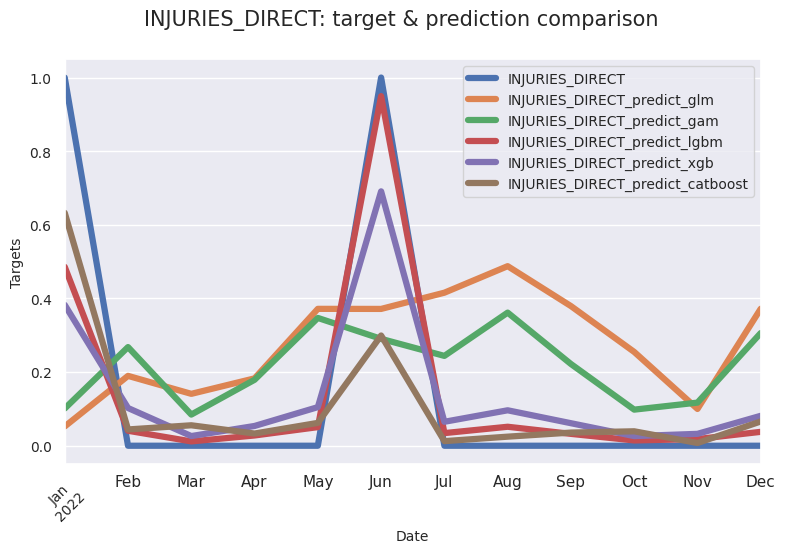

In [ ]:
# plot all models
test_df_agg = test_df.groupby(pd.Grouper(freq='M')).agg({
    'INJURIES_DIRECT': 'sum',
    'INJURIES_DIRECT_predict_glm': 'sum',
    'INJURIES_DIRECT_predict_gam': 'sum',
    'INJURIES_DIRECT_predict_lgbm': 'sum',
    'INJURIES_DIRECT_predict_xgb': 'sum',
    'INJURIES_DIRECT_predict_catboost': 'sum'
    })
plt.rcParams['figure.figsize'] = (8,5)
test_df_agg.plot(linewidth=4.5)
plt.suptitle('INJURIES_DIRECT: target & prediction comparison', fontsize=15)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Targets', fontsize=10)
plt.yticks(rotation=0,fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=10)
plt.show()

In [ ]:
# total score
score = pd.concat([score_glm, score_gam, score_lgbm, score_xgb, score_cat])
score

,model,rmse_train,rmse_test,mae_train,mae_test,mpd_train,mpd_test
0,glm,0.000731,0.000251,0.000018,0.000010,0.000212,0.000092
0,gam,0.000727,0.000251,0.000019,0.000009,0.000137,0.000084
0,lgbm,0.000605,0.000249,0.000016,0.000008,0.000037,0.000046
0,xgb,0.000679,0.000246,0.000018,0.000008,0.000058,0.000039
0,cat,0.000675,0.000250,0.000017,0.000009,0.000059,0.000053


#### Plot score results

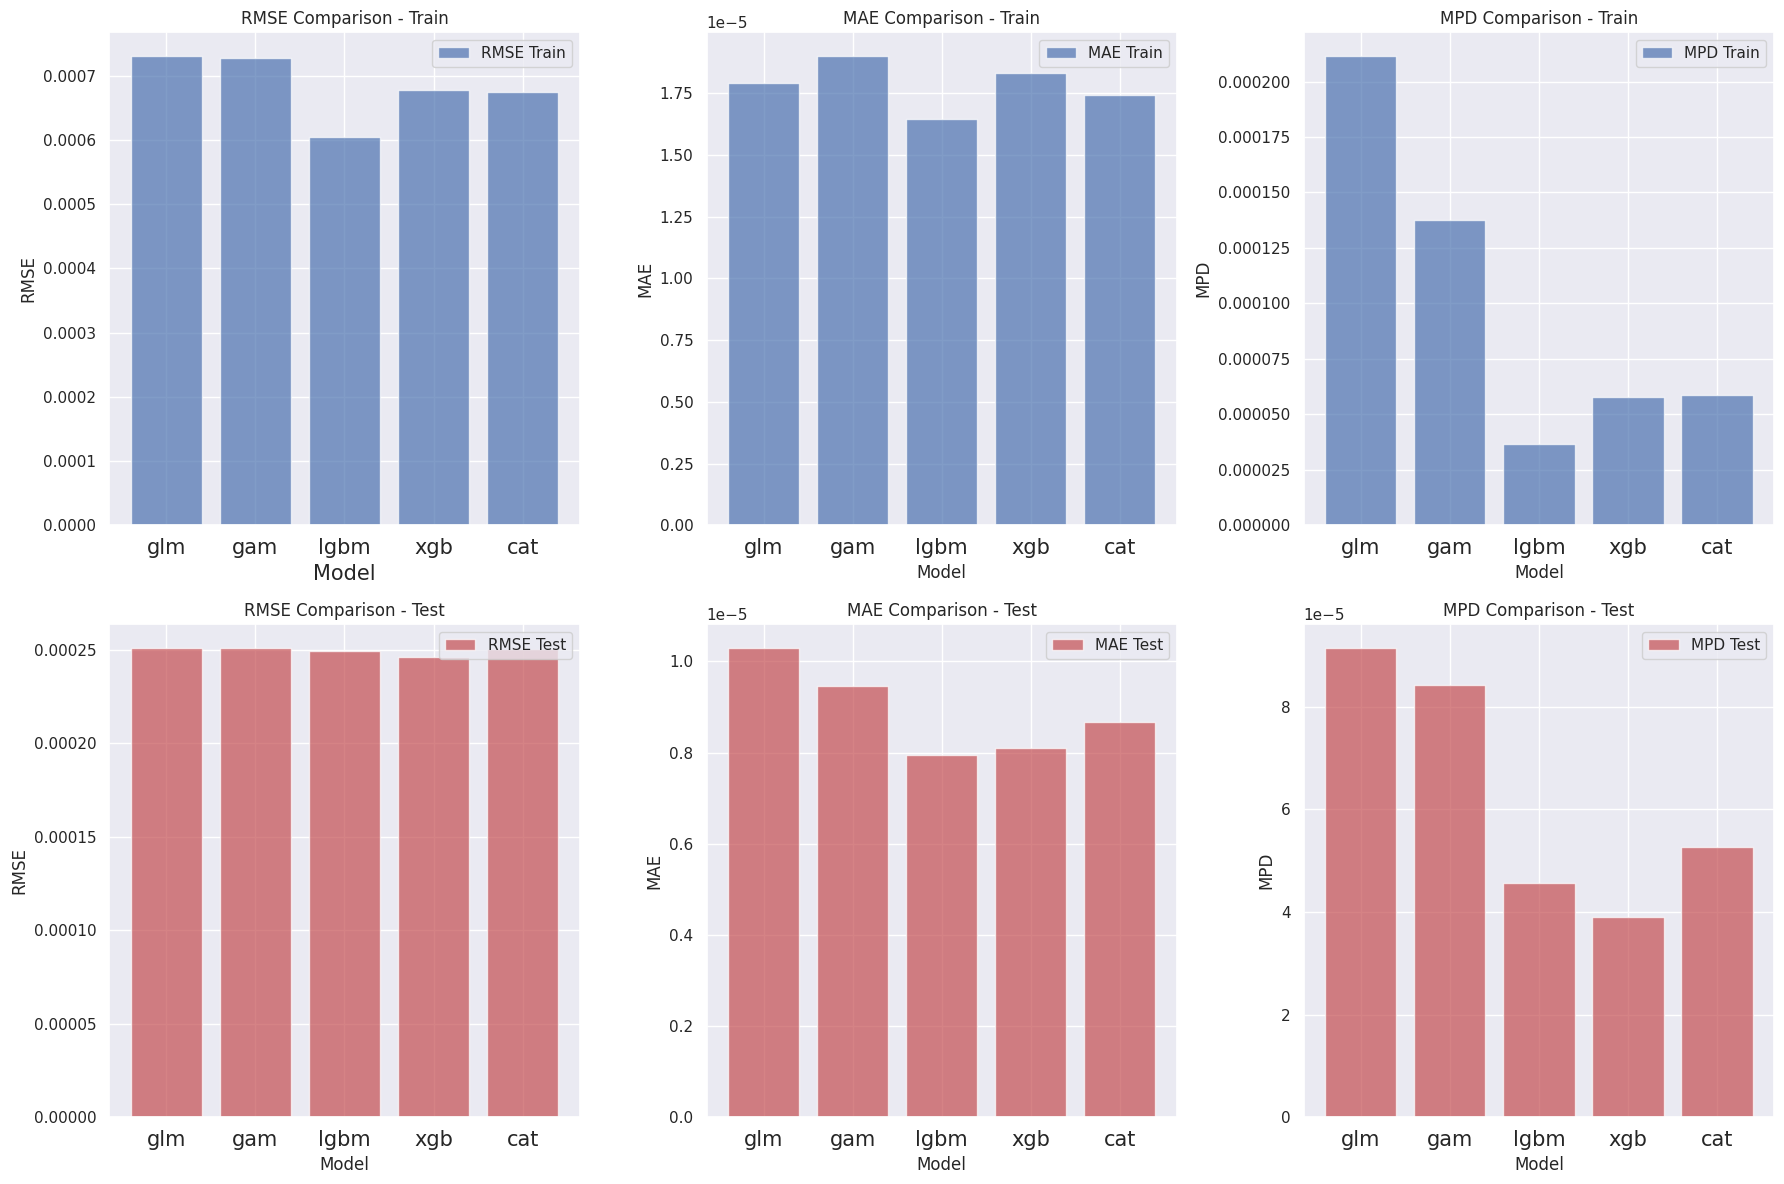

In [ ]:
# Reset the index of the DataFrame
score = score.reset_index(drop=True)

# Convert 'mpd_train' and 'mpd_test' to float type
score['mpd_train'] = score['mpd_train'].astype(float)
score['mpd_test'] = score['mpd_test'].astype(float)

# Plotting 6 charts with 3 per row
plt.figure(figsize=(18, 12))

# Plot RMSE comparison for Train and Test
plt.subplot(2, 3, 1)
plt.bar(score['model'], score['rmse_train'], color='b', alpha=0.7, label='RMSE Train')
plt.xlabel('Model',fontsize=15)
plt.ylabel('RMSE')
plt.xticks(fontsize=15)
plt.legend()
plt.title('RMSE Comparison - Train')

plt.subplot(2, 3, 4)
plt.bar(score['model'], score['rmse_test'], color='r', alpha=0.7, label='RMSE Test')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(fontsize=15)
plt.legend()
plt.title('RMSE Comparison - Test')

# Plot MAE comparison for Train and Test
plt.subplot(2, 3, 2)
plt.bar(score['model'], score['mae_train'], color='b', alpha=0.7, label='MAE Train')
plt.xlabel('Model')
plt.xticks(fontsize=15)
plt.ylabel('MAE')
plt.legend()
plt.title('MAE Comparison - Train')

plt.subplot(2, 3, 5)
plt.bar(score['model'], score['mae_test'], color='r', alpha=0.7, label='MAE Test')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(fontsize=15)
plt.legend()
plt.title('MAE Comparison - Test')

# Plot MPD comparison for Train and Test
plt.subplot(2, 3, 3)
plt.bar(score['model'], score['mpd_train'], color='b', alpha=0.7, label='MPD Train')
plt.xlabel('Model')
plt.ylabel('MPD')
plt.xticks(fontsize=15)
plt.legend()
plt.title('MPD Comparison - Train')

plt.subplot(2, 3, 6)
plt.bar(score['model'], score['mpd_test'], color='r', alpha=0.7, label='MPD Test')
plt.xlabel('Model')
plt.ylabel('MPD')
plt.xticks(fontsize=15)
plt.legend()
plt.title('MPD Comparison - Test')

plt.tight_layout()
plt.show()